### Predicting Times of Year for High Air Pollution

In [322]:
#
# Lucius Latham
# Alex White
# Faith Meyer
# Andrew Kivrak
#
# Predicting Times of Year for High Air Pollution

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d

# Load CSV file
print("Loading file...")
f = pd.read_csv('pollution_us_2000_2016.csv')

# Data cleaning
# Drop unnamed column which was the index for the csv data file
f.drop('Unnamed: 0', axis = 1, inplace = True)
# Drop variables we don't want to use
df = f[['State','Date Local','NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']]

# Drop those that are null
df = df.dropna(axis='rows')
#Drop Mexico as it isn't in the United states
df = df[df.State != 'Country Of Mexico']
df = df[df.State != 'District Of Columbia']
df = df[df.State != 'Michigan'] # Michigan doesn't have any days in the latter half.
# Check for duplicate values
df = df.drop_duplicates()
# Pull out the M/D from the Y-M-D so we can compute averages over all years.
df['Date Local'] = pd.to_datetime(df['Date Local'],format='%Y-%m-%d')
df['Date-M/D'] = df['Date Local'].dt.strftime('%m-%d')

#Setup a dataframe so that it is grouped by State and then by date
byDate = df.groupby(['State','Date-M/D']).mean()
groupedDF = byDate.groupby(level=0)
topNO = groupedDF['NO2 AQI'].mean().nlargest(5).index # Pick n largest Nitrous Dioxide offenders for all plots.
dfNO = groupedDF[['NO2 AQI', 'O3 AQI', 'SO2 AQI', 'CO AQI']]


Loading file...


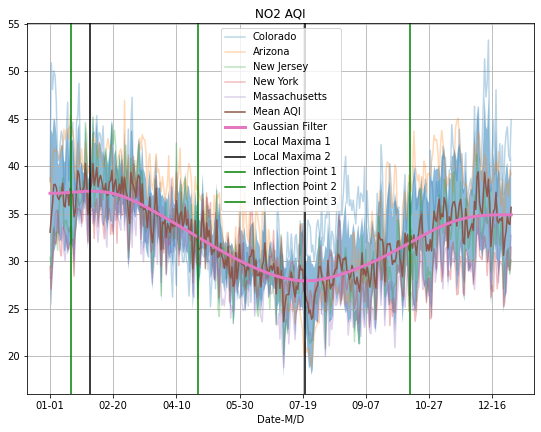

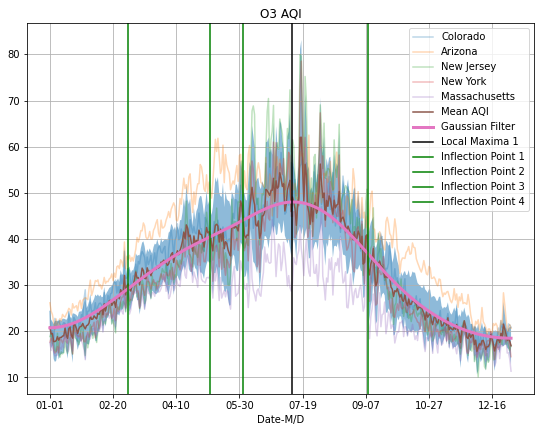

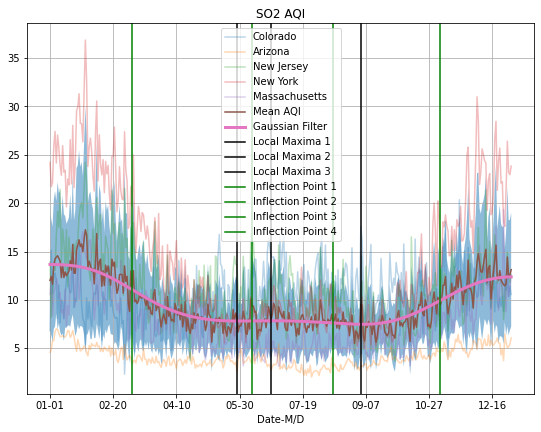

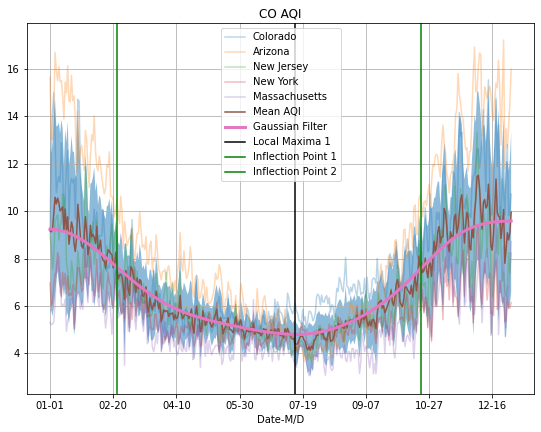

     Date-M/D       Mean       Dev Type
0       01-01  37.143262  6.116700  NO2
1       01-02  37.144162  9.319587  NO2
2       01-03  37.145940  7.309716  NO2
3       01-04  37.148598  7.062873  NO2
4       01-05  37.152110  6.746979  NO2
...       ...        ...       ...  ...
1459    12-27   9.579979  3.689626   CO
1460    12-28   9.581413  3.022233   CO
1461    12-29   9.582477  2.911051   CO
1462    12-30   9.583182  3.081075   CO
1463    12-31   9.583532  3.373986   CO

[1464 rows x 4 columns]


In [323]:
def outputGraph(col):
    # Plot each of the top N states' graphs for the year
    means = []
    plt.figure(figsize=(20,15))
    plt.subplot(221)
    for i in range(len(topNO)):
        mean = dfNO.get_group(topNO[i]).groupby('Date-M/D')[col].mean()
        mean.plot(alpha=0.3, label=topNO[i])

        # Append the calculated mean so we can compute the average of them later
        means.append(dfNO.get_group(topNO[i]).groupby('Date-M/D')[col].mean())

    # Collapse all states into one average graph
    y_vals = np.mean(means, axis=0)

    # Compute Gaussian filtering of the data to help trends appear for analysis
    smooth = gaussian_filter1d(y_vals, sigma=25)

    # Compute Std Dev of smoothed (have to do this manually since numpy will try to generate its own mean)
    # Calculate the variance of the values
    # This is 1/N * sum((x - mean(X))^2)
    var_means = sum((x - smooth) ** 2 for x in means) / len(means)
    # Take the square root of variance to get standard deviation
    std_dev = var_means ** 0.5

    # Plot points
    plt.plot(y_vals, label='Mean AQI')
    plt.fill_between(range(len(y_vals)), y_vals+std_dev, y_vals-std_dev, alpha=0.5)
    plt.plot(smooth, linewidth=3, label='Gaussian Filter')

    # Find first derivative to determine local maxima points
    pred_d1 = np.gradient(smooth)
    pred_d2 = np.gradient(pred_d1)
    lclMaxs = np.where(np.diff(np.sign(pred_d1)))[0]
    infls  = np.where(np.diff(np.sign(pred_d2)))[0]
    for i, lclMax in enumerate(lclMaxs, 1):
        plt.axvline(x=lclMax, color='k', label=f'Local Maxima {i}')
    for i, infl in enumerate(infls, 1):
        plt.axvline(x=infl, color='g', label=f'Inflection Point {i}')

    # Display plot
    plt.legend()
    plt.grid()
    plt.title(col)
    plt.show()

    return smooth, std_dev

# Output a graph for each particulate column and store the means and std devs for classification
no2_mean, no2_dev = outputGraph('NO2 AQI')
o3_mean, o3_dev = outputGraph('O3 AQI')
so2_mean, so2_dev = outputGraph('SO2 AQI')
co_mean, co_dev = outputGraph('CO AQI')

mean_dev_df = pd.DataFrame(data={
    'Mean': no2_mean,
    'Dev': no2_dev,
    'Type': 'NO2'
}).reset_index()
temp_df = pd.DataFrame(data={
    'Mean': o3_mean,
    'Dev': o3_dev,
    'Type': 'O3'
}).reset_index()
mean_dev_df = mean_dev_df.append(temp_df, ignore_index=True)
temp_df = pd.DataFrame(data={
    'Mean': so2_mean,
    'Dev': so2_dev,
    'Type': 'SO2'
}).reset_index()
mean_dev_df = mean_dev_df.append(temp_df, ignore_index=True)
temp_df = pd.DataFrame(data={
    'Mean': co_mean,
    'Dev': co_dev,
    'Type': 'CO'
}).reset_index()
mean_dev_df = mean_dev_df.append(temp_df, ignore_index=True)
print(mean_dev_df)

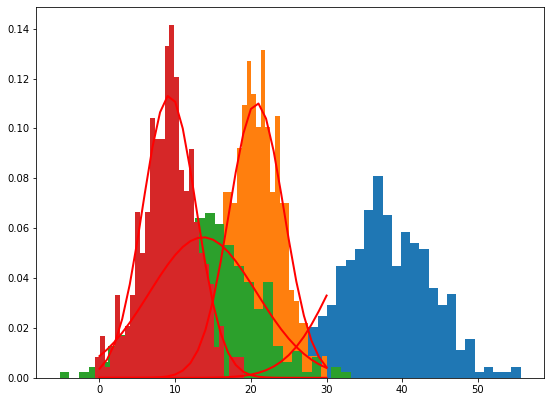

         Day   AQI           NO2            O3       SO2            CO
0      01-01   0.0  6.415110e-10  7.889250e-09  0.008719  3.627979e-03
1      01-01   1.0  1.708252e-09  3.705087e-08  0.011341  7.338889e-03
2      01-01   2.0  4.428858e-09  1.612150e-07  0.014460  1.369584e-02
3      01-01   3.0  1.117954e-08  6.499152e-07  0.018073  2.357976e-02
4      01-01   4.0  2.747566e-08  2.427461e-06  0.022142  3.745267e-02
...      ...   ...           ...           ...       ...           ...
11341  12-31  26.0  2.025601e-02  1.712383e-02  0.004755  8.550860e-07
11342  12-31  27.0  2.645609e-02  1.036780e-02  0.003173  1.934826e-07
11343  12-31  28.0  3.347078e-02  5.895634e-03  0.002058  4.009810e-08
11344  12-31  29.0  4.101799e-02  3.148712e-03  0.001297  7.611241e-09
11345  12-31  30.0  4.869130e-02  1.579406e-03  0.000794  1.323234e-09

[11346 rows x 6 columns]


In [324]:
# Plot the normal distributions for each day
traindf = pd.DataFrame(columns=['Day','AQI','NO2','O3','SO2','CO'])

for day in range(366):
    if (day == 0):
        plt.figure(figsize=(20,15))
        plt.subplot(221)
    dayAQIs = {}

    # Append each type's AQIs for the day into dayAQIs, then get cross-section for rows in pandas df
    for particle in mean_dev_df['Type'].unique():
        type_df = mean_dev_df.loc[mean_dev_df['Type'] == particle]
        sigma = type_df['Dev'].iloc[day]
        mu = type_df['Mean'].iloc[day]
        normal = np.random.normal(mu, sigma, 366) # This isn't the number of days, just looks cool
        if (day == 0):
            count, bins, ignored = plt.hist(normal, 30, density=True)
        bins = np.linspace(0, 30, 31)
        probDensity = 1/(sigma * np.sqrt(2 * np.pi)) * np.exp( - (bins - mu)**2 / (2 * sigma**2) )
        if (day == 0):
            plt.plot(bins, probDensity, linewidth=2, color='r')
        dayAQIs['AQI'] = bins
        dayAQIs[particle] = probDensity
    
    # Get cross-section, append rows
    dayAQIs['Day'] = mean_dev_df['Date-M/D'].unique()[day]
    temp = pd.DataFrame(dayAQIs)
    traindf = traindf.append(temp).reset_index(drop=True)
        
    if (day == 0):
        plt.show()

print(traindf)
